In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
import glob
import os
import cv2


In [3]:
# 이미지 불러오기 및 이미지 사이즈 재설정
def read_img(path):
    original_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    resize_img = cv2.resize(original_img, (800, 1000))
    
    return resize_img


In [22]:
# 배경 이미지를 삭제하기 위한 마스크 생성
def make_mask(original_img):
    # change to lab for masking mask
    img_mask = original_img.copy()
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_RGB2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_RGB2Lab)

    # blur
    blur_k = int((img_mask.mean()*0.5)//2)*2+1
    img_mask = cv2.medianBlur(img_mask, blur_k)

    # change to Grayscale for threshold
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_Lab2BGR)
    img_mask = cv2.cvtColor(img_mask, cv2.COLOR_BGR2GRAY)

    if img_mask.mean() > 100:
        th = img_mask.mean()*0.94
    else:
        th = img_mask.mean()
    
    ret, img_mask = cv2.threshold(img_mask, 110, 255, cv2.THRESH_BINARY)

    # mask based Max value of contours
    contours, hierarchy = cv2.findContours(img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img_mask.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    # Applying for dilation
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8))
    mask = cv2.dilate(mask,k)
    return mask


In [23]:
# 마스크를 이용하여 원본이미지의 배경 자르기 함수
def cut_mask(original_img, mask):
    img_for_cut = original_img.copy()
    height, width = img_for_cut.shape[:2]

    # mask
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    # converting color
    img_for_cut = cv2.cvtColor(img_for_cut, cv2.COLOR_BGR2GRAY) 

    img_for_cut = img_for_cut[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]

    # remove background
    masked = cv2.bitwise_and(img_for_cut, mask)

    return masked

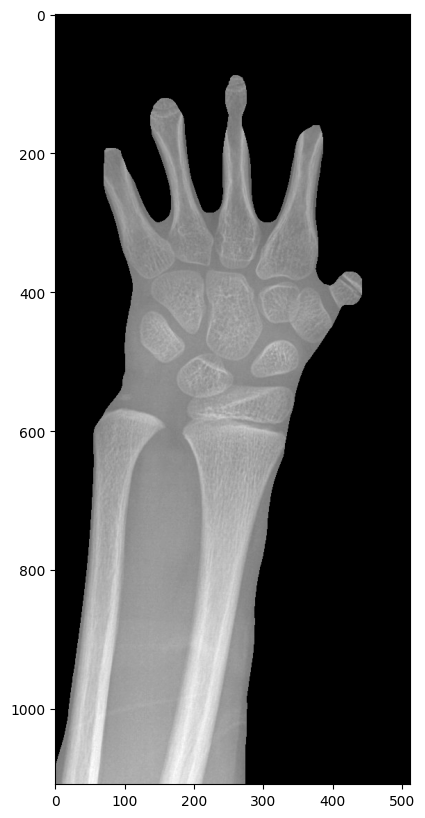

In [28]:
# 테스트를 위한 이미지 경로
image_path = '../BoneAge/Data/image/217_F.jpg'

# 이미지 불러오기
image = cv2.imread(image_path)

# 이미지 이진화
mask = make_mask(image)
masked = cut_mask(image, mask)

# 결과 이미지 출력
plt.figure(figsize=(15,10))
plt.imshow(masked, "gray")
plt.show()

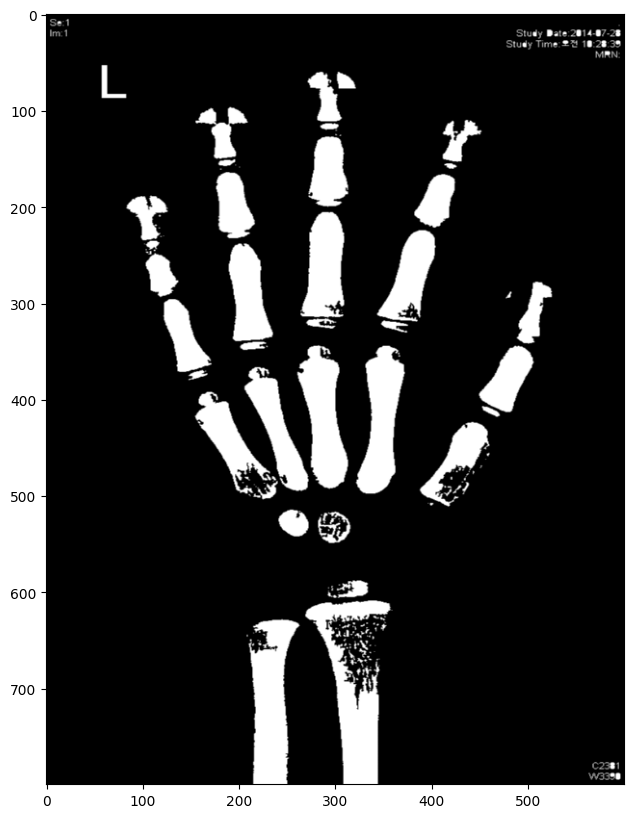

In [33]:
# 이미지 밝기 조절, 대비, 필터링 작업

def Decomposing(rotated_img,a,b,d,e):

    ######## Decomposing_stage_1 / [ Contours , Mask ] ########
    decomp_img_1 = rotated_img.copy()

    ## Adjusting brighness
    d_img1 = decomp_img_1.copy()
    cols, rows = d_img1.shape[:2]
    brightness1 = np.sum(d_img1) / (255 * cols * rows)

    if brightness1 > 0.8:
        decomp_img_1 = np.clip(decomp_img_1 - 80., 0, 255).astype(np.uint8)
    elif brightness1 > 0.75:
        decomp_img_1 = np.clip(decomp_img_1 - 50., 0, 255).astype(np.uint8)
    elif brightness1 > 0.65:
        decomp_img_1 = np.clip(decomp_img_1 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_1 = np.clip(decomp_img_1 - 10., 0, 255).astype(np.uint8)


    ## change to Lab
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_RGB2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2Lab)

    ## Morphology
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
    decomp_img_1 = cv2.morphologyEx(decomp_img_1, cv2.MORPH_TOPHAT, k) # Emphasis

    ## Filter
    decomp_img_1 = cv2.bilateralFilter(decomp_img_1,-1, d, e)

    ## Lab to gray for binary
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_Lab2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2GRAY)

    ## img_normalization
    decomp_img_1 = cv2.normalize(decomp_img_1, None, 0, 255, cv2.NORM_MINMAX)

    ## CLAHE
    decomp_img_1 = cv2.equalizeHist(decomp_img_1)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10)) 
    decomp_img_1= clahe.apply(decomp_img_1)          


    ## Threshold / value = img.mean()
    ret, mask = cv2.threshold(decomp_img_1,
                            122,
                            255,
                            cv2.THRESH_BINARY) 

    ## Extract object / same value pixels

    contours, hierarchy = cv2.findContours(mask, 
                                            cv2.RETR_EXTERNAL, # only outline
                                            cv2.CHAIN_APPROX_SIMPLE) # Contour vertex coordinate

    ## drawing Contours
    cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill


        
    ######## Decomposing_stage_2 / [ Brightness_Empahsis ] ########
    decomp_img_2 = rotated_img.copy()

    ## Brightness_Empahsis
    d_img2 = decomp_img_2.copy()
    cols, rows = d_img2.shape[:2]
    brightness2 = np.sum(d_img2) / (255 * cols * rows)

    ## Empahsis
    if brightness2 > 0.8:
        decomp_img_2 = np.clip(decomp_img_2 - 80., 0, 255).astype(np.uint8)
    elif brightness2 > 0.75:
        decomp_img_2 = np.clip(decomp_img_2 - 50., 0, 255).astype(np.uint8)
    elif brightness2 > 0.65:
        decomp_img_2 = np.clip(decomp_img_2 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_2 = np.clip(decomp_img_2 - 10., 0, 255).astype(np.uint8)


    ## Morphology
    k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
    decomp_img_2 = cv2.morphologyEx(decomp_img_2, cv2.MORPH_TOPHAT, k2)

    ## contrast
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2RGB)
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2GRAY)

    if decomp_img_2.mean() <= 15:
        low = decomp_img_2.mean() * 3.2
        high = decomp_img_2.mean() * 3.6
    elif decomp_img_2.mean() <= 20:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.6
    else:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.7

    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))
    h, w = decomp_img_2.shape
    img_ = np.zeros(decomp_img_2.shape, dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (decomp_img_2[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp

    decomp_img_2 = img_.copy()


    ######## Decomposing_Final_stage / [ Result ] ########
    ### Bone empahsis / bitwise (mask)
    ## Morphology
    ## Contours
    contours, hierarchy = cv2.findContours(decomp_img_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(decomp_img_2, contours, -1, (255, 255, 255), -1)

    ## Bitwise (mask) / print white parts

    decomp_img_2 = cv2.bitwise_and(decomp_img_2, mask) 

    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_GRAY2BGR)
    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))

    bone_extraction = cv2.resize(decomp_img_2, (600, 800))

    return bone_extraction


# 테스트를 위한 이미지 경로
image_path = '../BoneAge/Data/image/6_F.jpg'

# 이미지 불러오기
image = cv2.imread(image_path)

# 이미지 이진화
bone_extraction = Decomposing(image, 60, 55, 50, 25)

# 결과 이미지 출력
plt.figure(figsize=(15,10))
plt.imshow(bone_extraction, "gray")
plt.show()

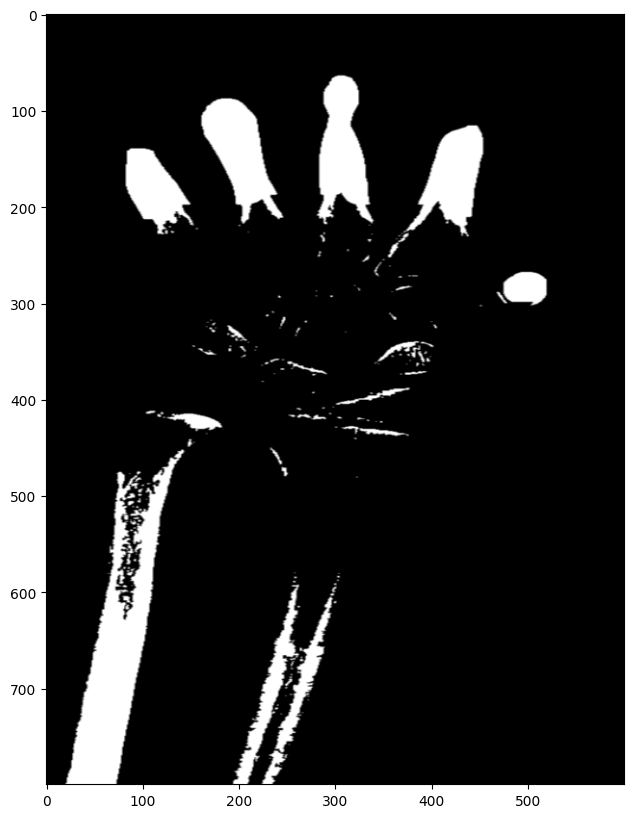

In [27]:
# 테스트를 위한 이미지 경로
image_path = '../BoneAge/Data/image/217_F.jpg'

# 이미지 불러오기
image = cv2.imread(image_path)

# 이미지 이진화
mask = make_mask(image)
masked = cut_mask(image, mask)
bone_extraction = Decomposing(masked, 60, 55, 50, 25)

# 결과 이미지 출력
plt.figure(figsize=(15,10))
plt.imshow(bone_extraction, "gray")
plt.show()

# 이미지 회전

In [123]:
def find_finger_tip(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find finger tip (topmost point)
    finger_tip = tuple(contours[0][contours[0][:, :, 1].argmin()][0])
    return finger_tip

def find_weight_center(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find extreme points (leftmost, rightmost)
    leftmost = tuple(contours[0][contours[0][:, :, 0].argmin()][0])
    rightmost = tuple(contours[0][contours[0][:, :, 0].argmax()][0])
    # Calculate weight center
    weight_center = ((leftmost[0] + rightmost[0]) // 2, (leftmost[1] + rightmost[1]) // 2)
    return weight_center

def rotate_image(image):
    # Find finger tip and weight center
    finger_tip = find_finger_tip(image)
    weight_center = find_weight_center(image)
    
    # Draw finger tip and weight center on image
    cv2.circle(image, finger_tip, 5, (0, 0, 255), -1)
    cv2.circle(image, weight_center, 5, (0, 255, 0), -1)
    
    # Calculate angle to rotate
    angle = np.arctan2(finger_tip[1] - weight_center[1], finger_tip[0] - weight_center[0]) * 180 / np.pi
    
    # Rotate image
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return rotated_image

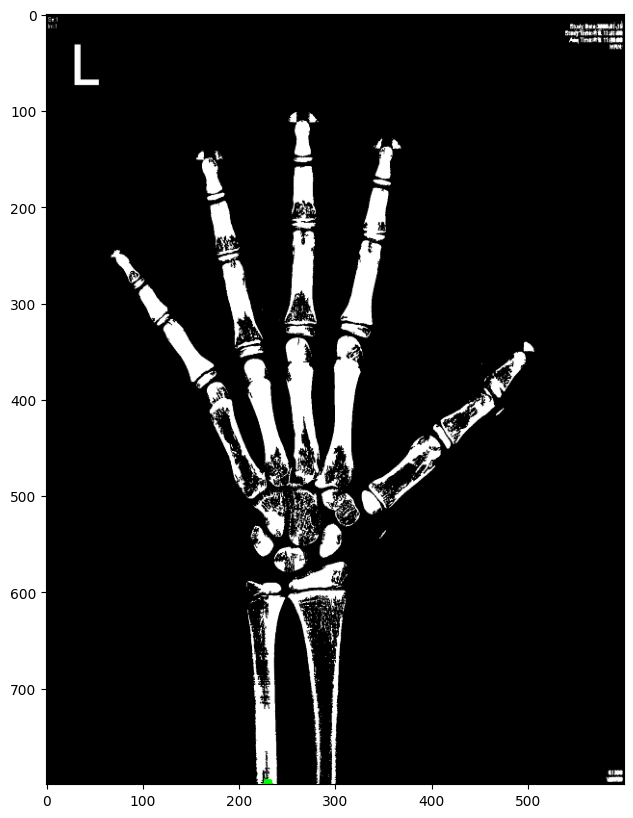

In [124]:
# 테스트를 위한 이미지 경로
image_path = '../BoneAge/Data/image/226_F.jpg'

# 이미지 불러오기
image = cv2.imread(image_path)

# 이미지 이진화
bone_extraction = Decomposing(image, 60, 55, 50, 25)
rotated_image = rotate_image(bone_extraction)

# 결과 이미지 출력
plt.figure(figsize=(15,10))
plt.imshow(rotated_image, "gray")
plt.show()

# 여기서부터 테스트


In [ ]:
def result(path):
    try:
        resize_img = read_img(path)
        #img_center = find_bright_boundary(resize_img)
        binarized_image = binarize_image
        return resize_img
    except:
        print("error")
        

In [ ]:
# 이미지 경로
test_img1 = '../BoneAge/Data/image/225_F.jpg'
test_img2 = '../BoneAge/Data/image/226_F.jpg'
test_img3 = '../BoneAge/Data/image/217_F.jpg'
test_img4 = '../BoneAge/Data/image/321_F.jpg'

Text(0.5, 1.0, '321_F')

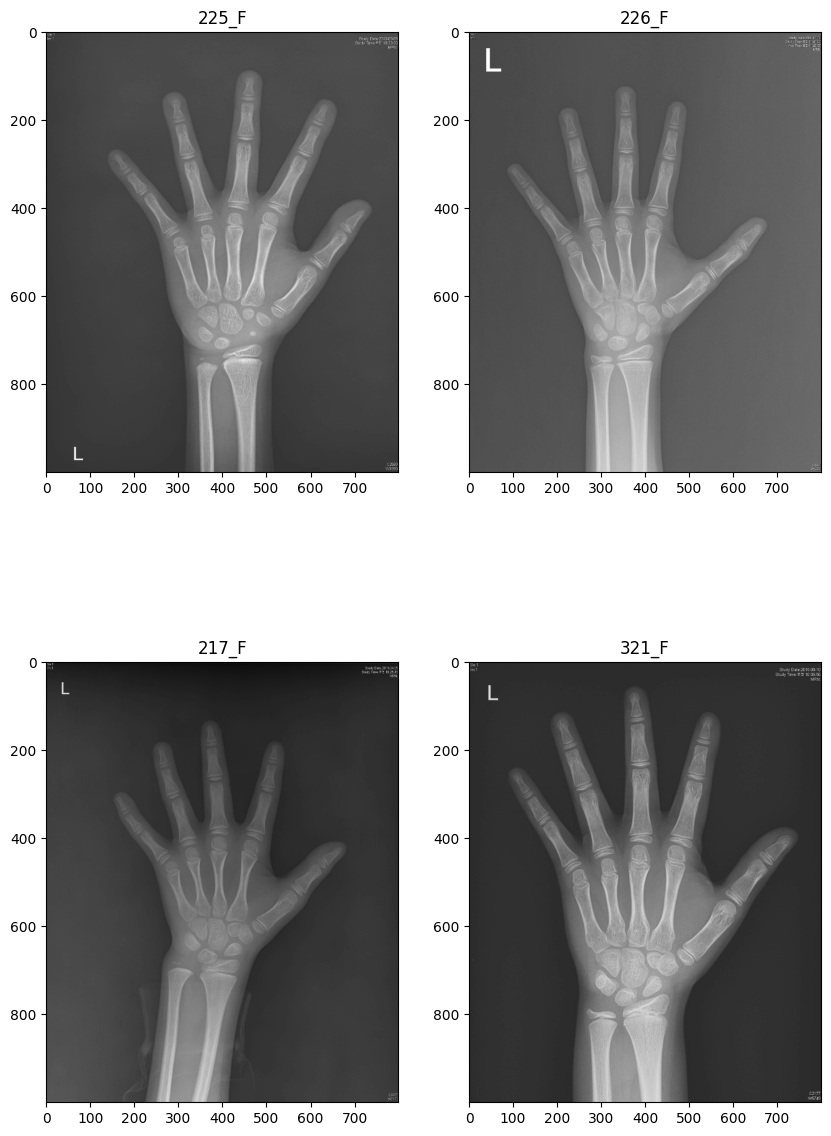

In [ ]:
a = result(test_img1)
b = result(test_img2)
c = result(test_img3)
d = result(test_img4)

plt.figure(figsize=(10, 15))
plt.subplot(2, 2, 1)
plt.imshow(a, "gray")
plt.title("225_F")

plt.subplot(2, 2, 2)
plt.imshow(b, "gray")
plt.title("226_F")

plt.subplot(2, 2, 3)
plt.imshow(c, "gray")
plt.title("217_F")

plt.subplot(2, 2, 4)
plt.imshow(d, "gray")
plt.title("321_F")
